In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from src.classifier import Classifier
from src.data import get_balanced_dataset
from src.utils import (
    plot_accuracy_by_class_barplot,
    plot_fixed_points_similarity_heatmap,
)

In [ ]:
# Data
N = 500
P = 10
C = 10
p = 0.4
train_data_dir = "data/train"
test_data_dir = "data/test"

# Model
num_layers = 5
lambda_left = 2.0
lambda_right = 2.0
lambda_x = 5.0
lambda_y = 5.0
J_D = 0.2
sparse_readout = False

# Training
num_epochs = 10
max_steps = 50
lr = 0.003
threshold = 1.5
eval_interval = 1

rng = np.random.default_rng(10)

## Data

In [ ]:
train_inputs, train_targets, train_metadata, train_class_prototypes = (
    get_balanced_dataset(
        N,
        P,
        C,
        p,
        train_data_dir,
        None,
        rng,
        shuffle=True,
        load_if_available=True,
        dump=True,
    )
)
eval_inputs, eval_targets, eval_metadata, eval_class_prototypes = get_balanced_dataset(
    N,
    P,
    C,
    p,
    test_data_dir,
    train_class_prototypes,
    rng,
    shuffle=False,
    load_if_available=True,
    dump=True,
)

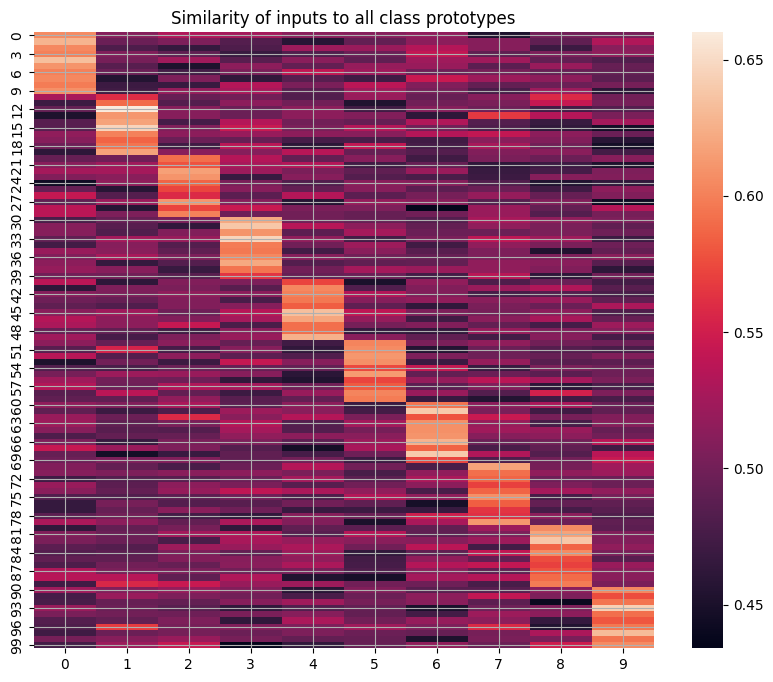

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))

sim_with_all_prototypes = np.zeros((P * C, C))
for i in range(P * C):
    for j in range(C):
        sim_with_all_prototypes[i, j] = np.mean(
            eval_class_prototypes[j] == eval_inputs[i]
        )

sns.heatmap(sim_with_all_prototypes, ax=ax)
ax.set_title("Similarity of inputs to all class prototypes")
ax.grid()

plt.show()

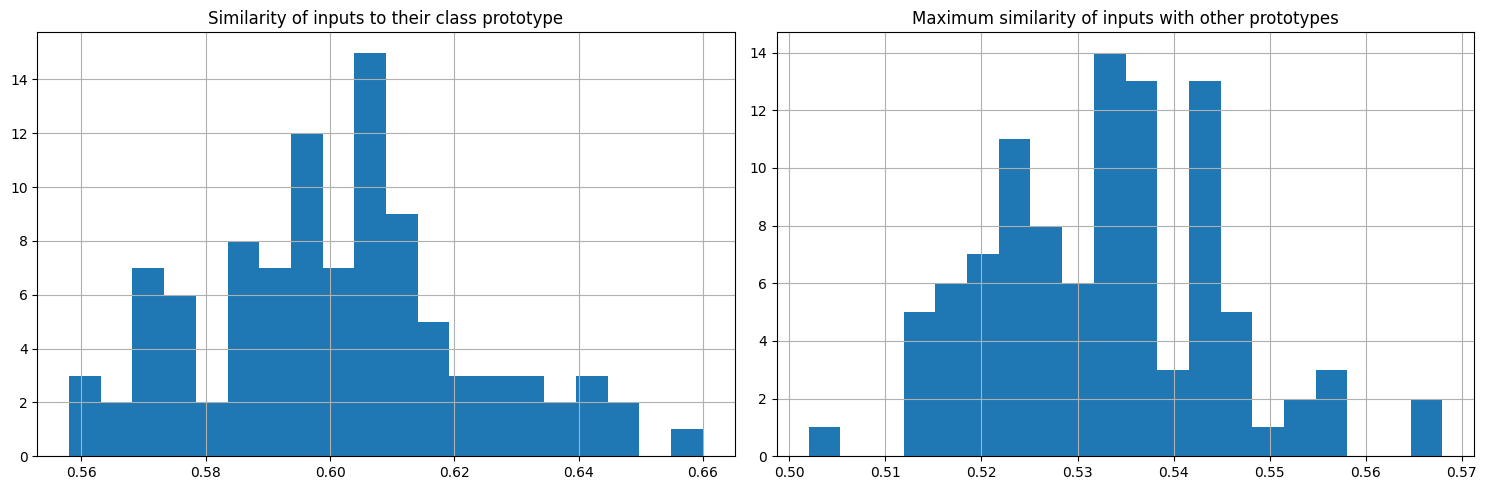

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sim_with_prototype = np.mean(
    eval_class_prototypes[np.argmax(eval_targets, axis=1)] == eval_inputs, axis=1
)
axes[0].hist(sim_with_prototype, bins=20)
axes[0].set_title("Similarity of inputs to their class prototype")
axes[0].grid()

max_sim_with_wrong_prototypes = np.max(
    sim_with_all_prototypes * (1 - eval_targets), axis=1
)
axes[1].hist(max_sim_with_wrong_prototypes, bins=20)
axes[1].set_title("Maximum similarity of inputs with other prototypes")
axes[1].grid()

plt.tight_layout()
plt.show()

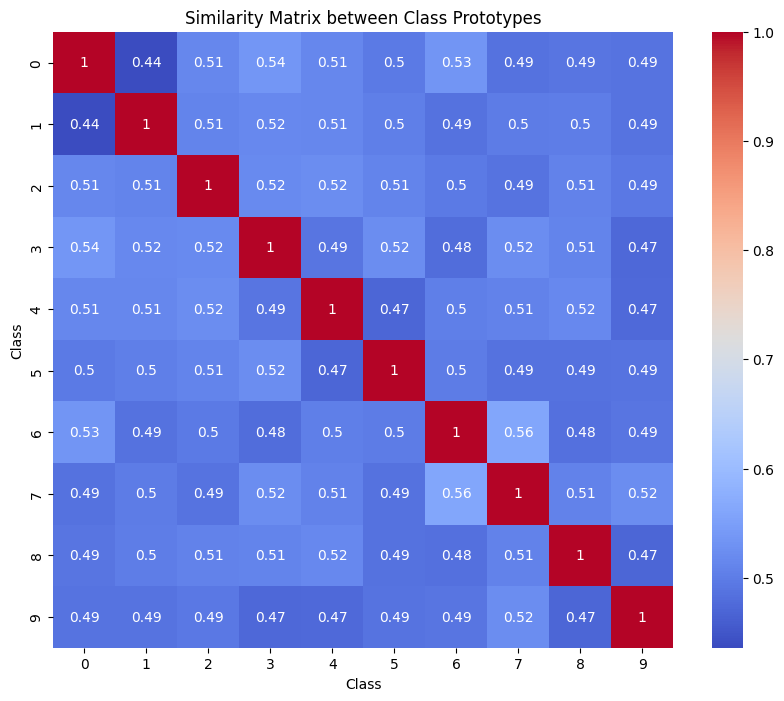

In [17]:
similarity_matrix = np.zeros((C, C))
for i in range(C):
    for j in range(C):
        similarity_matrix[i, j] = np.mean(
            eval_class_prototypes[i] == eval_class_prototypes[j]
        )

plt.figure(figsize=(10, 8))
sns.heatmap(
    similarity_matrix,
    annot=True,
    cmap="coolwarm",
)
plt.title("Similarity Matrix between Class Prototypes")
plt.xlabel("Class")
plt.ylabel("Class")
plt.show()

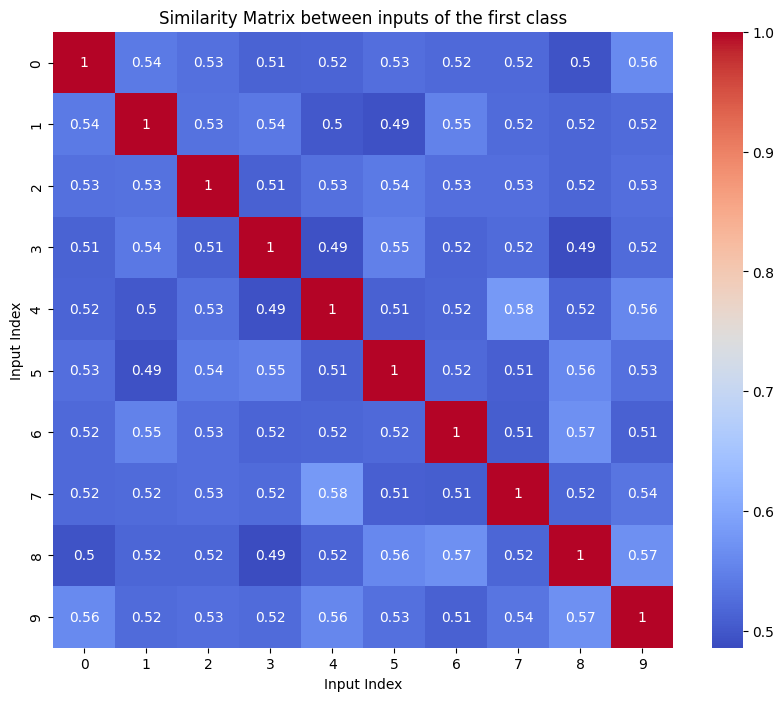

In [ ]:
similarity_matrix = np.zeros((P, P))
for i in range(P):
    for j in range(P):
        similarity_matrix[i, j] = np.mean(eval_inputs[i] == eval_inputs[j])

plt.figure(figsize=(10, 8))
sns.heatmap(
    similarity_matrix,
    annot=True,
    cmap="coolwarm",
)
plt.title("Similarity Matrix between inputs of the first class")
plt.xlabel("Input Index")
plt.ylabel("Input Index")
plt.show()

## Model

In [ ]:
model = Classifier(
    num_layers,
    N,
    C,
    lambda_left,
    lambda_right,
    lambda_x,
    lambda_y,
    J_D,
    rng,
    sparse_readout=sparse_readout,
)

In [9]:
train_acc_history, eval_acc_history = model.train_loop(
    num_epochs,
    train_inputs,
    train_targets,
    max_steps,
    lr,
    threshold,
    eval_interval,
    eval_inputs,
    eval_targets,
    rng,
)

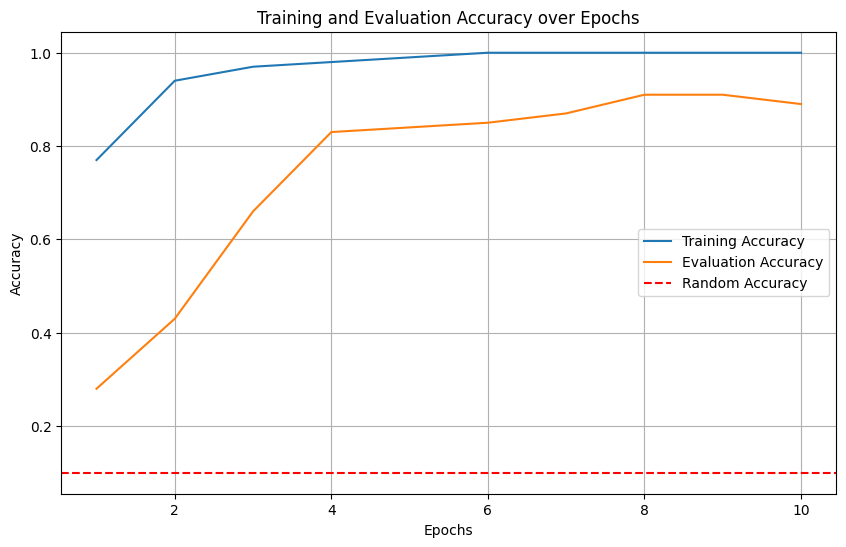

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

epochs = range(1, num_epochs + 1)

ax.plot(epochs, train_acc_history, label="Training Accuracy")
ax.plot(epochs, eval_acc_history, label="Evaluation Accuracy")

random_accuracy = 1 / C
ax.axhline(y=random_accuracy, color="r", linestyle="--", label="Random Accuracy")

ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_title("Training and Evaluation Accuracy over Epochs")
ax.legend()
ax.grid()

plt.show()

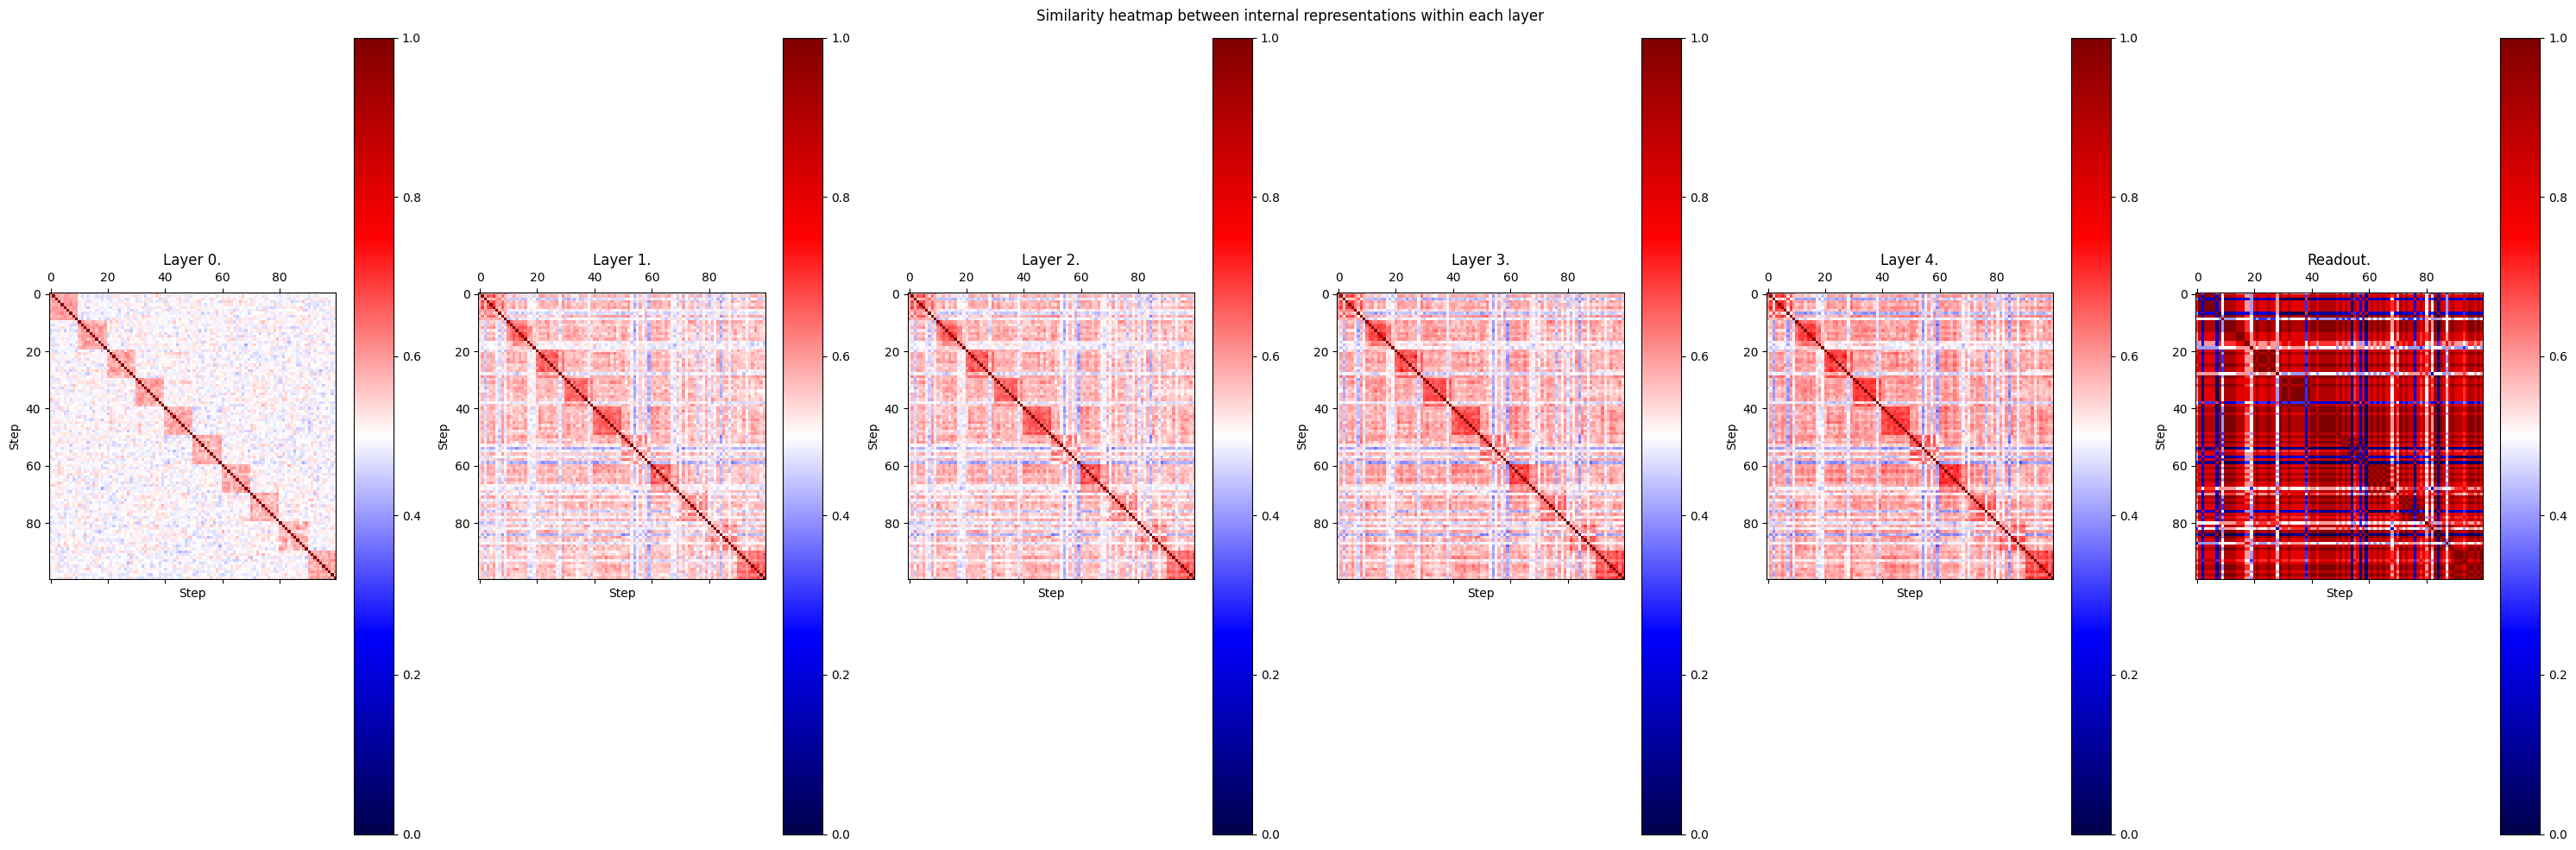

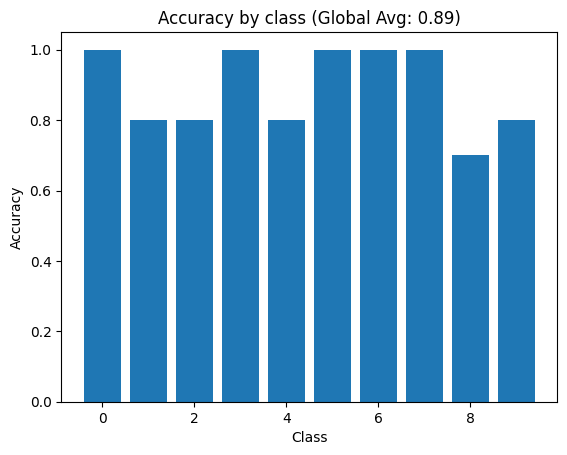

In [11]:
eval_metrics = model.evaluate(eval_inputs, eval_targets, max_steps, rng)
fig = plot_fixed_points_similarity_heatmap(eval_metrics["fixed_points"])
plt.show()
fig = plot_accuracy_by_class_barplot(eval_metrics["accuracy_by_class"])
plt.show()

## MLP Teacher

In [6]:
import torch
import torch.nn as nn

from src.data import prepare_hm_data

D = 30  # latent dimension
C = 2  # number of classes
P = 10  # patterns per class
P_eval = 10
M = 784  # teacher_mlp output dimension
L = 1  # number of hidden layers in teacher_mlp
width = 60  # width for hidden layers
activation = nn.ReLU()
seed = 0
binarize = True

(
    train_inputs,
    train_labels,
    eval_inputs,
    eval_labels,
    teacher_linear,
    teacher_mlp,
) = prepare_hm_data(D, C, P, P_eval, M, L, width, activation, seed, binarize)

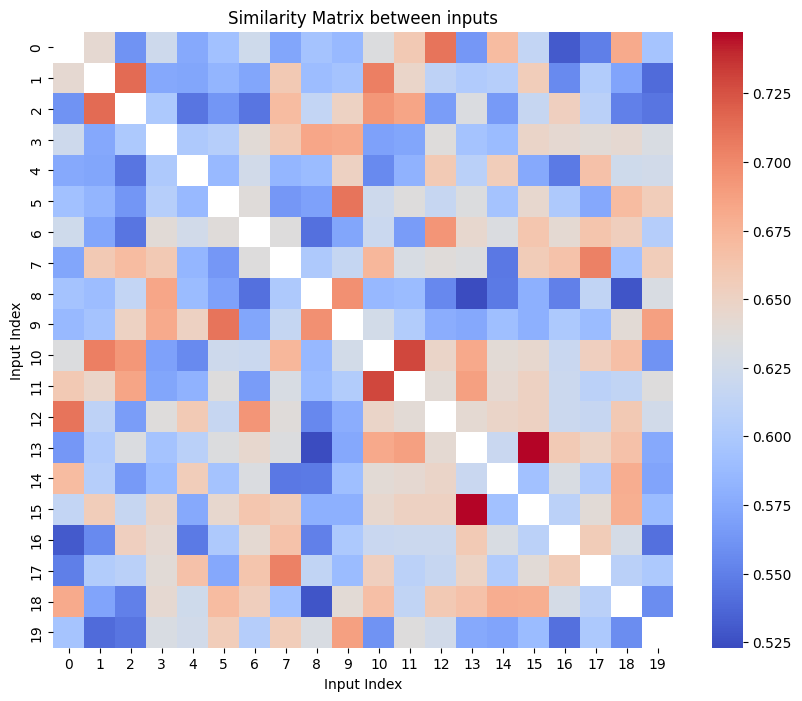

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

num_classes = C

similarity_matrix = np.zeros((P_eval * num_classes, P_eval * num_classes))
for i in range(P_eval * num_classes):
    for j in range(P_eval * num_classes):
        similarity_matrix[i, j] = torch.mean(
            eval_inputs[i] == eval_inputs[j], dtype=torch.float32
        )
        if i == j:
            similarity_matrix[i, j] = None

plt.figure(figsize=(10, 8))
sns.heatmap(
    similarity_matrix,
    annot=False,
    cmap="coolwarm",
)
plt.title("Similarity Matrix between inputs")
plt.xlabel("Input Index")
plt.ylabel("Input Index")
plt.show()

## MNIST

In [140]:
import torch

seed = 10
device = "mps"

# Data
N = 100
P = 1000
P_eval = 100
C = 10
binarize = True

# Model
H = 200
num_layers = 1
max_steps = 10
init_mode = "zeros"
fc_left = True
fc_right = False

# Couplings
lambda_x = 6.0
lambda_y = 12.0
lambda_l = 4.0
lambda_r = 2.1
lambda_wback = 1.5
lambda_internal = 1.0
lambda_fc = 0.001
J_D = 0.2

# Training
num_epochs = 10
batch_size = 16
lr_J = 0.05
lr_W = 0.05
threshold_hidden = 2.5
threshold_readout = 2.5
weight_decay_J = 0.1
weight_decay_W = 0.1

# Evaluation
eval_interval = 1
skip_representations = True
skip_couplings = False

In [141]:
# Assemble the pieces
lr = [lr_J] * num_layers + [lr_W] * 2
weight_decay = [weight_decay_J] * num_layers + [weight_decay_W] * 2
threshold = [threshold_hidden] * num_layers + [threshold_readout]
lambda_left = [lambda_x] + [lambda_l] * (num_layers - 1) + [1.0]
lambda_right = [lambda_r] * (num_layers - 1) + [lambda_wback] + [lambda_y]

In [142]:
from src.data import prepare_mnist

train_inputs, train_targets, eval_inputs, eval_targets, projection_matrix = (
    prepare_mnist(
        P * C,
        P_eval * C,
        N,
        binarize,
        seed,
        shuffle=True,
    )
)
train_inputs = train_inputs.to(device)
train_targets = train_targets.to(device)
eval_inputs = eval_inputs.to(device)
eval_targets = eval_targets.to(device)

In [143]:
import os

from src.batch_me_if_u_can import BatchMeIfUCan
from src.handler import Handler

output_dir = "prova"
os.makedirs(output_dir, exist_ok=True)

model_kwargs = {
    "num_layers": num_layers,
    "N": N,
    "C": C,
    "lambda_left": lambda_left,
    "lambda_right": lambda_right,
    "lambda_internal": lambda_internal,
    "J_D": J_D,
    "device": device,
    "seed": seed,
    "lr": torch.tensor(lr),
    "threshold": torch.tensor(threshold),
    "weight_decay": torch.tensor(weight_decay),
    "init_mode": init_mode,
}
if fc_left or fc_right:
    model_kwargs["fc_left"] = fc_left
    model_kwargs["fc_right"] = fc_right
    model_kwargs["lambda_fc"] = lambda_fc
    model_kwargs["H"] = H
    model_cls = BatchMeIfUCan  # noqa: F821
else:
    model_cls = Classifier
model = model_cls(**model_kwargs)
handler = Handler(
    model,
    init_mode,
    skip_representations,
    skip_couplings,
    "prova",
)

In [144]:
idx = 0
i = 1

torch.set_printoptions(precision=4)
print("Couplings:")
print(model.couplings[idx][:, H * i : H * (i + 1)])
print("Learning rates:")
print(model.lr[idx][:, H * i : H * (i + 1)])
print("Weight decay:")
print(model.weight_decay[idx][:, H * i : H * (i + 1)])
print("Is learnable:")
print(model.is_learnable[idx][:, H * i : H * (i + 1)])

Couplings:
tensor([[ 0.2000,  0.0044,  0.0087,  ...,  0.0970, -0.0313,  0.2398],
        [-0.0298,  0.2000, -0.0253,  ...,  0.0415,  0.0769, -0.0011],
        [-0.0101, -0.0573,  0.2000,  ..., -0.0482, -0.0468, -0.0414],
        ...,
        [ 0.0658,  0.0837,  0.0529,  ...,  0.2000,  0.0775, -0.0145],
        [-0.0246,  0.0015,  0.0153,  ...,  0.0859,  0.2000,  0.0085],
        [-0.0432,  0.0635, -0.0137,  ..., -0.1207, -0.1523,  0.2000]],
       device='mps:0')
Learning rates:
tensor([[0.0000, 0.0035, 0.0035,  ..., 0.0035, 0.0035, 0.0035],
        [0.0035, 0.0000, 0.0035,  ..., 0.0035, 0.0035, 0.0035],
        [0.0035, 0.0035, 0.0000,  ..., 0.0035, 0.0035, 0.0035],
        ...,
        [0.0035, 0.0035, 0.0035,  ..., 0.0000, 0.0035, 0.0035],
        [0.0035, 0.0035, 0.0035,  ..., 0.0035, 0.0000, 0.0035],
        [0.0035, 0.0035, 0.0035,  ..., 0.0035, 0.0035, 0.0000]],
       device='mps:0')
Weight decay:
tensor([[0.0000, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
        [0.0004, 

In [145]:
idxs = [1234]

x = train_inputs[idxs]
y = train_targets[idxs]
state = model.initialize_state(x, y, "zeros")
final_state, num_sweeps, unsat = model.relax(state, max_steps, ignore_right=0)
_, neurons, readout, _ = model.split_state(final_state)
label = y.argmax(dim=1)
pred = readout.argmax(dim=1)

In [146]:
print("Fraction usat:")
print(unsat.mean(dim=-1, dtype=torch.float32))

print("Similarity of ferromagnetic cylinder with input:")
print(torch.mean(neurons[:, :, :N] == x.unsqueeze(1), dim=-1, dtype=torch.float32))
print("Readout shows correct label:")
print(pred == label)

Fraction usat:
tensor([[0., 0.]], device='mps:0')
Similarity of ferromagnetic cylinder with input:
tensor([[1.]], device='mps:0')
Readout shows correct label:
tensor([True], device='mps:0')


In [157]:
neurons[:, -1, :H]

tensor([[-1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,  1., -1., -1.,
          1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1., -1., -1., -1., -1.,
         -1., -1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,
         -1.,  1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1.,  1.,  1., -1.,
         -1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,
         -1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,
         -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,
          1.,  1.,  1., -1.,  1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1.,
          1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,
          1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,
         -1.,  1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.

In [162]:
print("Overlap of Wback prototypes with last layer neurons.")
print("\n-- Correct class --")
correct_overlap_full = (
    torch.einsum(
        "bi,bi->b", model.W_back[:H, label].transpose(0, 1), neurons[:, -1, :H]
    )
    / model.W_back[:H, label].transpose(0, 1).norm(dim=1, keepdim=True)
    / neurons[:, -1, :H].norm(dim=1, keepdim=True)
)
correct_overlap_free = (
    torch.einsum(
        "bi,bi->b", model.W_back[N:H, label].transpose(0, 1), neurons[:, -1, N:H]
    )
    / model.W_back[N:H, label].transpose(0, 1).norm(dim=1, keepdim=True)
    / neurons[:, -1, N:H].norm(dim=1, keepdim=True)
)
print("Full layer:")
print(correct_overlap_full)
print("Only free neurons:")
print(correct_overlap_free)

overlaps_full = (
    torch.einsum(
        "ci,bi->bc", model.W_back[:H, range(C)].transpose(0, 1), neurons[:, -1, :H]
    )
    / model.W_back[:H, range(C)].transpose(0, 1).norm(dim=1, keepdim=True)
    / neurons[:, -1, :H].norm(dim=1, keepdim=True)
)
overlaps_free = (
    torch.einsum(
        "ci,bi->bc", model.W_back[N:H, range(C)].transpose(0, 1), neurons[:, -1, N:H]
    )
    / model.W_back[N:H, range(C)].transpose(0, 1).norm(dim=1, keepdim=True)
    / neurons[:, -1, N:H].norm(dim=1, keepdim=True)
)
print("\n-- Wrong classes average --")
idxs_left = [[i] for i in range(len(label))]
idxs_right = [[i for i in range(C) if i != t] for t in label]
print("Full layer:")
print(
    overlaps_full[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)
print("Only free neurons:")
print(
    overlaps_free[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)

print("\n-- Wrong classes --")
print("Full layer:")
print(overlaps_full[idxs_left, idxs_right])
print("Only free neurons:")
print(overlaps_free[idxs_left, idxs_right])

Overlap of Wback prototypes with last layer neurons.

-- Correct class --
Full layer:
tensor([[0.0766]], device='mps:0')
Only free neurons:
tensor([[0.0369]], device='mps:0')

-- Wrong classes average --
Full layer:
tensor([-0.0979], device='mps:0')
Only free neurons:
tensor([-0.2491], device='mps:0')

-- Wrong classes --
Full layer:
tensor([[ 0.0376, -0.1280,  0.0776, -0.0992, -0.1200, -0.1482, -0.1056, -0.1825,
         -0.2125]], device='mps:0')
Only free neurons:
tensor([[-0.1263, -0.1707, -0.0561, -0.2986, -0.3075, -0.2892, -0.2580, -0.3276,
         -0.4079]], device='mps:0')


In [167]:
print("Overlap of Wforth prototypes with last layer neurons.")
print("\n-- Correct class --")
correct_overlap_full = (
    torch.einsum("bi,bi->b", model.W_forth[label, :H], neurons[:, -1, :H])
    / model.W_forth[label, :H].norm(dim=1, keepdim=True)
    / neurons[:, -1, :H].norm(dim=1, keepdim=True)
)
correct_overlap_free = (
    torch.einsum("bi,bi->b", model.W_forth[label, N:H], neurons[:, -1, N:H])
    / model.W_forth[label, N:H].norm(dim=1, keepdim=True)
    / neurons[:, -1, N:H].norm(dim=1, keepdim=True)
)
print("Full layer:")
print(correct_overlap_full)
print("Only free neurons:")
print(correct_overlap_free)

overlaps_full = (
    torch.einsum("ci,bi->bc", model.W_forth[range(C), :H], neurons[:, -1, :H])
    / model.W_forth[range(C), :H].norm(dim=1, keepdim=True)
    / neurons[:, -1, :H].norm(dim=1, keepdim=True)
)
overlaps_free = (
    torch.einsum("ci,bi->bc", model.W_forth[range(C), N:H], neurons[:, -1, N:H])
    / model.W_forth[range(C), N:H].norm(dim=1, keepdim=True)
    / neurons[:, -1, N:H].norm(dim=1, keepdim=True)
)
print("\n-- Wrong classes average --")
idxs_left = [[i] for i in range(len(label))]
idxs_right = [[i for i in range(C) if i != t] for t in label]
print("Full layer:")
print(
    overlaps_full[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)
print("Only free neurons:")
print(
    overlaps_free[idxs_left, idxs_right].mean(dim=-1, dtype=torch.float32),
)

print("\n-- Wrong classes --")
print("Full layer:")
print(overlaps_full[idxs_left, idxs_right])
print("Only free neurons:")
print(overlaps_free[idxs_left, idxs_right])

Overlap of Wforth prototypes with last layer neurons.

-- Correct class --
Full layer:
tensor([[0.0766]], device='mps:0')
Only free neurons:
tensor([[0.0369]], device='mps:0')

-- Wrong classes average --
Full layer:
tensor([-0.0979], device='mps:0')
Only free neurons:
tensor([-0.2491], device='mps:0')

-- Wrong classes --
Full layer:
tensor([[ 0.0376, -0.1280,  0.0776, -0.0992, -0.1200, -0.1482, -0.1056, -0.1825,
         -0.2125]], device='mps:0')
Only free neurons:
tensor([[-0.1263, -0.1707, -0.0561, -0.2986, -0.3075, -0.2892, -0.2580, -0.3276,
         -0.4079]], device='mps:0')


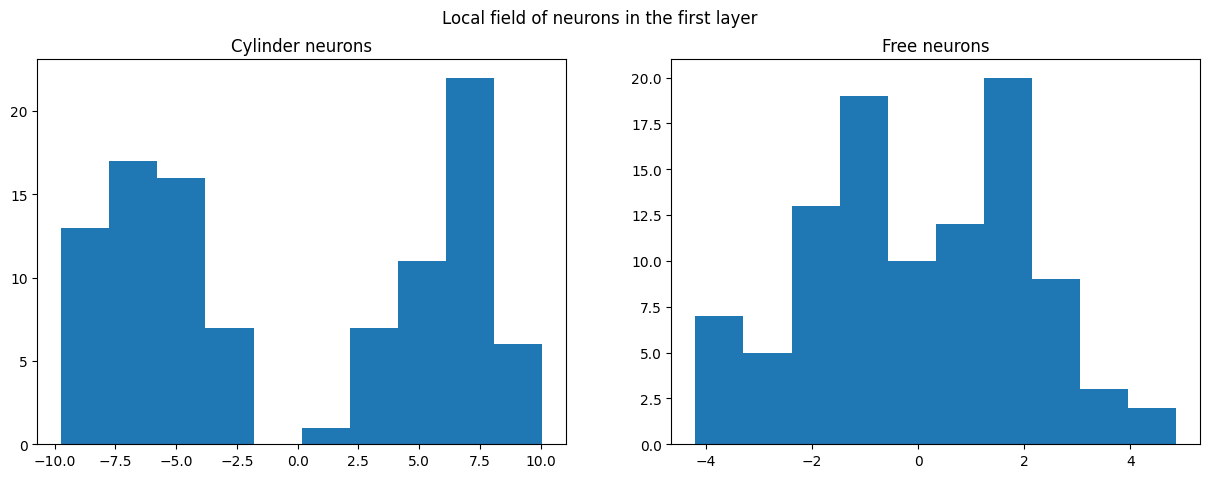

In [184]:
from matplotlib import pyplot as plt

fields = model.local_field(final_state, ignore_right=0)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(fields[:, 0, :N].flatten().cpu())
axs[1].hist(fields[:, 0, N:H].flatten().cpu())
fig.suptitle("Local field of neurons in the first layer")
axs[0].set_title("Cylinder neurons")
axs[1].set_title("Free neurons")
plt.show()

### Training

In [6]:
logs = handler.train_loop(
    num_epochs,
    train_inputs,
    train_targets,
    max_steps,
    batch_size,
    eval_interval=eval_interval,
    eval_inputs=eval_inputs,
    eval_targets=eval_targets,
)

Final Eval Accuracy: 0.84


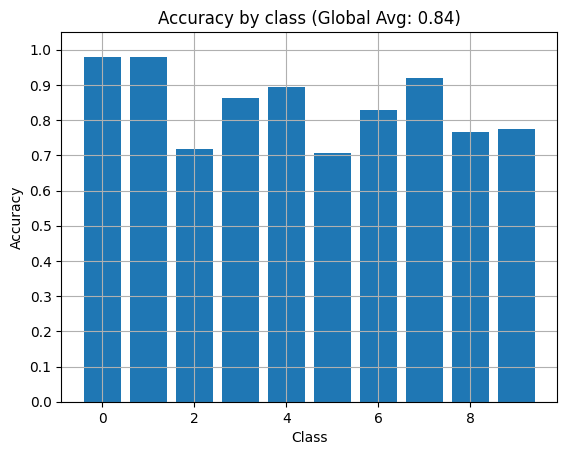

In [ ]:
import matplotlib.pyplot as plt

from src.utils import plot_accuracy_by_class_barplot

eval_metrics = handler.evaluate(eval_inputs, eval_targets, max_steps)
print(f"Final Eval Accuracy: {eval_metrics['overall_accuracy']:.2f}")
fig = plot_accuracy_by_class_barplot(eval_metrics["accuracy_by_class"])
plt.show()

In [ ]:
out = model.inference(eval_inputs, max_steps)
logits = out[0]
predictions = torch.argmax(logits, dim=1)
gt = torch.argmax(eval_targets, dim=1)

In [24]:
import torch.nn.functional as F

probas = F.softmax(logits, dim=1)
probas_wrong = probas[gt != predictions]
probas_right = probas[gt == predictions]

diff_wrong = (
    (
        probas_wrong.topk(2, dim=1).values[:, 0]
        - probas_wrong.topk(2, dim=1).values[:, 1]
    )
    .mean()
    .item()
)
diff_right = (
    (
        probas_right.topk(2, dim=1).values[:, 0]
        - probas_right.topk(2, dim=1).values[:, 1]
    )
    .mean()
    .item()
)

print(f"Average difference (wrong predictions): {diff_wrong}")
print(f"Average difference (correct predictions): {diff_right}")

Average difference (wrong predictions): 0.4420371651649475
Average difference (correct predictions): 0.8776503801345825


In [ ]:
proba_of_gt_wrong = probas_wrong[range(probas_wrong.size(0)), gt[gt != predictions]]
avg_proba_of_gt_wrong = proba_of_gt_wrong.mean().item()
print(
    f"Average probability of correct ground truth class among probas_wrong: {avg_proba_of_gt_wrong}"
)

Average probability of correct ground truth class among probas_wrong: 0.14338774979114532


In [ ]:
proba_of_gt_right = probas_right[range(probas_right.size(0)), gt[gt == predictions]]
avg_proba_of_gt_right = proba_of_gt_right.mean().item()
print(
    f"Average probability of correct ground truth class among probas_right: {avg_proba_of_gt_right}"
)

Average probability of correct ground truth class among probas_right: 0.924145519733429
